In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

In [219]:
data = pd.read_csv('Airline_review.csv')
airlines = data.copy()

In [220]:
def process_ratings_column(df, rating_column, groupby_column):
# Convert the rating column to numeric
#eplace 'n' values as NaN
    df[rating_column] = pd.to_numeric(df[rating_column], errors='coerce')

# Replace 'n' values with the median rating
    df[rating_column] = df.groupby(groupby_column)[rating_column].transform(lambda x: x.fillna(x.median()))

# Convert the rating column to integer type
# fillna as 0
    df[rating_column] = df[rating_column].fillna(0).astype('int')

process_ratings_column(airlines, 'Overall_Rating', 'Airline Name')
process_ratings_column(airlines, 'Seat Comfort', 'Airline Name')
process_ratings_column(airlines, 'Cabin Staff Service', 'Airline Name')
process_ratings_column(airlines, 'Food & Beverages', 'Airline Name')
process_ratings_column(airlines, 'Ground Service', 'Airline Name')
process_ratings_column(airlines, 'Inflight Entertainment', 'Airline Name')
process_ratings_column(airlines, 'Wifi & Connectivity', 'Airline Name')
process_ratings_column(airlines, 'Value For Money', 'Airline Name')

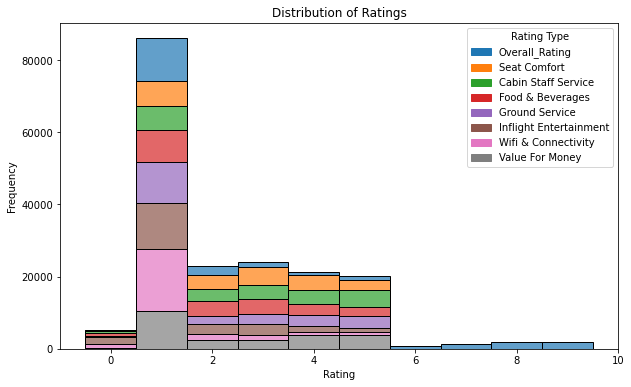

In [221]:
df_long = pd.melt(airlines.copy(), value_vars=['Overall_Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money'], var_name='RatingType', value_name='Rating')

plt.figure(figsize=(10, 6))

ax = sns.histplot(df_long, x='Rating', bins=range(1, 7), discrete=True, kde=False,
                  hue='RatingType', multiple='stack', alpha=0.7)  # Set alpha for transparency

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
handles = [Patch(color=color, label=label) for color, label in zip(sns.color_palette(), df_long['RatingType'].unique())]
plt.legend(handles=handles, title='Rating Type')

plt.show()

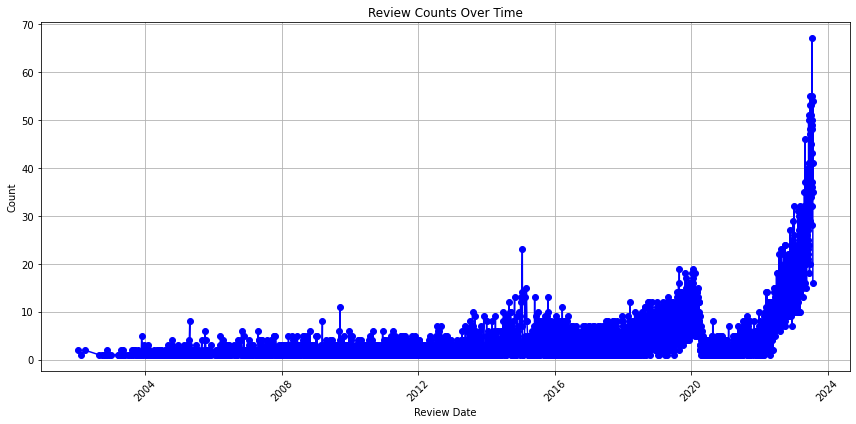

In [222]:
def convert_to_datetime(date_string):
    return parser.parse(date_string)

airlines['Review Date'] = airlines['Review Date'].apply(convert_to_datetime)
airlines['Verified'] = airlines['Verified'].astype(bool)
airlines['Recommended'] = airlines['Recommended'].map({'yes': True, 'no': False})
counts = airlines.groupby('Review Date').count().reset_index()[['Review Date','Unnamed: 0']]

plt.figure(figsize=(12, 6))
plt.plot(counts['Review Date'].values, counts['Unnamed: 0'].values, marker='o', linestyle='-', color='b')
plt.title('Review Counts Over Time')
plt.xlabel('Review Date')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

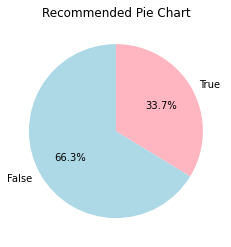

In [223]:
recommended_counts = airlines['Recommended'].value_counts()

# Plot a pie chart
plt.pie(recommended_counts, labels=recommended_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])
plt.title('Recommended Pie Chart')
plt.savefig('Recommended_Pie_Chart.png')
plt.show()

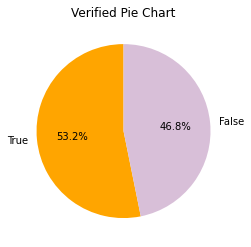

In [224]:
verified_counts = airlines['Verified'].value_counts()

# Plot a pie chart
plt.pie(verified_counts, labels=verified_counts.index, autopct='%1.1f%%', startangle=90, colors=['orange', 'thistle'])
plt.title('Verified Pie Chart')
plt.savefig('Verified_Pie_Chart.png')
plt.show()

In [225]:
def traveller(ty):
    if ty == 'Business':
        return 0
    elif ty == 'Couple Leisure':
        return 1
    elif ty == 'Family Leisure':
        return 2
    else:
        return 3
        
    
def seat(ty):
    if ty == 'Business Class':
        return 0
    elif ty == 'Economy Class':
        return 1
    elif ty == 'First Class':
        return 2
    else:
        return 3


## Baseline

In [227]:
to_int = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
               'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended']
for r in to_int:
    airlines[r] = airlines[r].astype(int)

In [233]:
X_b = airlines[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
               'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money']]
y_b = airlines['Overall_Rating']


X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_b, y_b, test_size=0.2, random_state=42)


baseline = LinearRegression(fit_intercept=False)
baseline.fit(X_trainb, y_trainb)

y_pred_b = baseline.predict(X_testb)

mse_b = mean_squared_error(y_testb, y_pred_b)
fvu_b = mse_b / np.var(y_testb)
r2_b = 1 - fvu_b
mse_b,fvu_b, r2_b

(5.134306295344894, 0.6390881358442239, 0.36091186415577614)

In [255]:
mae_b = mean_absolute_error(y_testb, y_pred_b)
rmse_b = np.sqrt(mse_b)
mae_b,rmse_b

(1.575073807419921, 2.2659007690860813)

## Linear Regression with more features

In [241]:
# Prepare X and y
airlines['Type Of Traveller'] = airlines['Type Of Traveller'].apply(traveller)
airlines['Seat Type'] = airlines['Seat Type'].apply(seat)


X = airlines[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
               'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended',
               'Type Of Traveller', 'Seat Type']]
y = airlines['Overall_Rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [242]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
fvu_lr = mse_lr / np.var(y_test)
r2_lr = 1 - fvu_lr
mse_lr,fvu_lr, r2_lr

(4.389607617682505, 0.546392440983864, 0.45360755901613603)

In [256]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr,rmse_lr

(1.529709955944369, 2.09513904495203)

## RandomForestRegressor

In [244]:
rf = RandomForestRegressor(n_estimators=100, random_state=30)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
fvu_rf = mse_rf / np.var(y_test)
r2_rf = 1 - fvu_rf
mse_rf,fvu_rf, r2_rf

(3.4816446466690287, 0.4333745707631692, 0.5666254292368308)

In [257]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf,rmse_rf

(1.153656973902195, 1.8659165701255318)

## XGBRegressor

In [245]:
xgb = XGBRegressor(n_estimators=100, random_state=55)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
fvu_xgb = mse_xgb / np.var(y_test)
r2_xgb = 1 - fvu_xgb
mse_xgb,fvu_xgb, r2_xgb

(3.2802845531194196, 0.4083104551032378, 0.5916895448967622)

In [258]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb,rmse_xgb

(1.1375957645130261, 1.8111555850117955)

## Add TF-IDF

In [246]:
# Prepare X and y
X2 = airlines[['Review', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
               'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money', 'Recommended',
               'Type Of Traveller', 'Seat Type']]
y2 = airlines['Overall_Rating']


X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [247]:
# TF-IDF feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Combine features using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'Review'),
        ('other_features', 'passthrough', ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
                                           'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity',
                                           'Value For Money', 'Recommended', 'Type Of Traveller', 'Seat Type'])
    ])

## Linear Regression 

In [248]:
# Fit the model
# Create a pipeline with both TF-IDF and existing features
lr_tfidf = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', LinearRegression(fit_intercept=False))
])

lr_tfidf.fit(X_train2, y_train2)

# Predict on the test set
y_pred_lrW = lr_tfidf.predict(X_test2)

In [249]:
# Evaluate the model
mse_lrW = mean_squared_error(y_test2, y_pred_lrW)
fvu_lrW = mse_lrW / np.var(y_test2)
r2_lrW = 1 - fvu_lrW
mse_lrW,fvu_lrW, r2_lrW

(4.797901830919314, 0.5972144941695258, 0.40278550583047423)

In [259]:
mae_lrW = mean_absolute_error(y_test2, y_pred_lrW)
rmse_lrW = np.sqrt(mse_lrW)
mae_lrW,rmse_lrW

(1.6318152781877906, 2.190411338292266)

## XGBRegressor

In [250]:
xgb_tfidf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_regressor', XGBRegressor(n_estimators=100, random_state=55))
])

In [251]:
# Fit the model
xgb_tfidf.fit(X_train2, y_train2)

# Predict on the test set
y_pred_xgbW = xgb_tfidf.predict(X_test2)

# Evaluate the model
mse_xgbW = mean_squared_error(y_test2, y_pred_xgbW)
fvu_xgbW = mse_xgbW / np.var(y_test2)
r2_xgbW = 1 - fvu_xgbW
mse_xgbW,fvu_xgbW, r2_xgbW

(3.1680700194741225, 0.39434265244467354, 0.6056573475553264)

In [260]:
mae_xgbW = mean_absolute_error(y_test2, y_pred_xgbW)
rmse_xgbW = np.sqrt(mse_xgbW)
mae_xgbW,rmse_xgbW

(1.1423359654892031, 1.7799073064275348)

## RandomForestRegressor

In [252]:
rf_tfidf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_regressor', RandomForestRegressor(n_estimators=100, random_state=30))
])

In [253]:
# Fit the model
rf_tfidf.fit(X_train2, y_train2)

# Predict on the test set
y_pred_rfW = rf_tfidf.predict(X_test2)

# Evaluate the model
mse_rfW = mean_squared_error(y_test2, y_pred_rfW)
fvu_rfW = mse_rfW / np.var(y_test2)
r2_rfW = 1 - fvu_rfW
mse_rfW,fvu_rfW, r2_rfW

(3.0455024595469258, 0.3790861661964986, 0.6209138338035014)

In [261]:
mae_rfW = mean_absolute_error(y_test2, y_pred_rfW)
rmse_rfW = np.sqrt(mse_rfW)
mae_rfW,rmse_rfW

(1.0886364617044229, 1.745136802530657)